<a href="https://colab.research.google.com/github/joelbecv/MNA_WORKSPACE/blob/main/IAYML_WS/SEMANA8TAREA/notebooks/MNA_IAyAA_Actividad_Pronosticos_Series_de_Tiempo_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**

**Dr Luis Eduardo Falcón Morales**

**Tecnológico de Monterrey**
### **Actividad Individual: Pronósticos con Series de Tiempo**


#### **Nombre: JOEL ARTURO BECERRIL BALDERAS**
#### **Matrícula: A01797427**

Modelos para predicción de un problema de serie de tiempo:

* **1. Modelo ingenuo**
* **2. Modelo ARIMA**
* **3. Modelo Prophet**
* **4. Modelo LSTM**

In [1]:
!pip install prophet --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.7
    Uninstalling prophet-1.1.7:
      Successfully uninstalled prophet-1.1.7


# **0 - CARGA DE DATOS PREPARACIÓN Y LIBRERIAS**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
import math

from prophet import Prophet
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # gráficos de autocorrelación

In [7]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "monthly_champagne_sales.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "piyushagni5/monthly-sales-of-french-champagne",
  file_path,
)

print("First 5 records:", df.head())

/tmp/ipython-input-1736715378.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'monthly-sales-of-french-champagne' dataset.
First 5 records:      Month  Sales
0  1964-01   2815
1  1964-02   2672
2  1964-03   2755
3  1964-04   2721
4  1964-05   2946


In [9]:
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [12]:
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])
df.head()

,ds,y
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      105 non-null    datetime64[ns]
 1   y       105 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [17]:
# Hagamos una copia del DataFrame df con índices temporales:
df_temp = df.copy()
df_temp.set_index('ds', inplace=True)
df_temp

,y
ds,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [16]:
#VEMOS PRe post de crreación de indice con la fecha
print(df.shape)
print(df_temp.shape)

(105, 2)
(105, 1)


In [18]:
# Especificamos  que nuestros datos están registrados con una frecuencia mensual
# al inicio del mes (cada día 01 de cada mes):
df_temp.index.freq = 'MS'  # MS-Month-start-frequency o M=ME-Month-end-frequency

df_temp.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq='MS')

In [20]:
df_temp

,y
ds,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [21]:
# Particionamos en entrenamiento y prueba como DataFrames de Pandas:

train = df_temp.iloc[0:-12,:]

test = df_temp.iloc[-12:,:]   # Seleccionamos los datos del último año para predicción de Test.

In [22]:
train.shape

(93, 1)

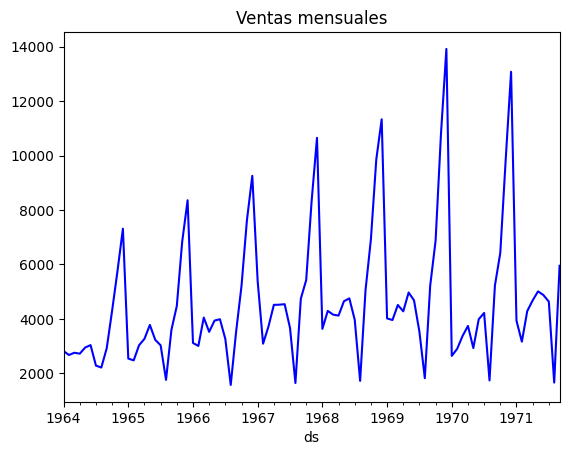

In [24]:
# Gráfico con la periodicidad mensual:
train['y'].plot(title='Ventas mensuales', style='-b')
plt.show()

# **1 - Modelo ingenuo**

In [ ]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++


In [25]:
test['y'].values

array([ 6981,  9851, 12670,  4348,  3564,  4577,  4788,  4618,  5312,
        4298,  1413,  5877])

In [26]:
history = [x for x in train['y'].values]   # Definimos "history" donde de manera incremental se irán agregando registros mensuales.
predictions = list()    # Lista que contendrá las predicciones del modelo ingenuo.

for i in range(len(test['y'])):
  # Obtenemos las predicciones:
  yhat = history[-1]   # La primera vez, tomamos el último dato del Train, en las siguientes, se van agregando los datos de Test.
  predictions.append(yhat)

  # Observaciones-registros reales:
  obs = test.iloc[i]['y']   # Ahora vamos tomando los datos de Test.
  history.append(obs)  # Vamos agregando a "history" (que ya tiene todo los de Train) en cada iteración, un dato más de los de Test.
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# Calculamos la raíz del error cuadrático medio (RMSE):
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % rmse)

>Esperado-real = 6981, Predicción = 5951.000
>Esperado-real = 9851, Predicción = 6981.000
>Esperado-real = 12670, Predicción = 9851.000
>Esperado-real = 4348, Predicción = 12670.000
>Esperado-real = 3564, Predicción = 4348.000
>Esperado-real = 4577, Predicción = 3564.000
>Esperado-real = 4788, Predicción = 4577.000
>Esperado-real = 4618, Predicción = 4788.000
>Esperado-real = 5312, Predicción = 4618.000
>Esperado-real = 4298, Predicción = 5312.000
>Esperado-real = 1413, Predicción = 4298.000
>Esperado-real = 5877, Predicción = 1413.000

Error-Modelo-Naive: RMSE: 3135.480


Este valor de predicción RMSE nos dice que en promedio el error es de aproximadamente más menos 3135 por cada predicción hecha. Este será nuestro error RMSE a mejorar.

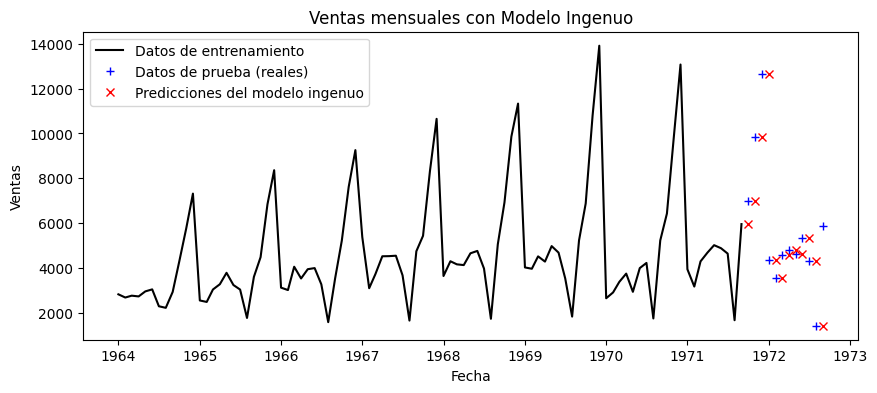

In [28]:
# Grafiquemos los resultados:

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train['y'], '-k', label='Datos de entrenamiento')  # Datos de entrenamiento de históricos.
plt.plot(test['y'], '+b', label='Datos de prueba (reales)')    # Datos de prueba reales  del útimo año a predecir.
plt.plot(test.index, predictions, 'xr', label='Predicciones del modelo ingenuo')  # Predicciones del modelo ingenuo para el último año.
plt.title('Ventas mensuales con Modelo Ingenuo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

Aunque pareciera que las predicciones fueron bastante exactas en el gráfico, en realidad están todas desfasadas un año.

# **2 - Modelo ARIMA**

In [ ]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

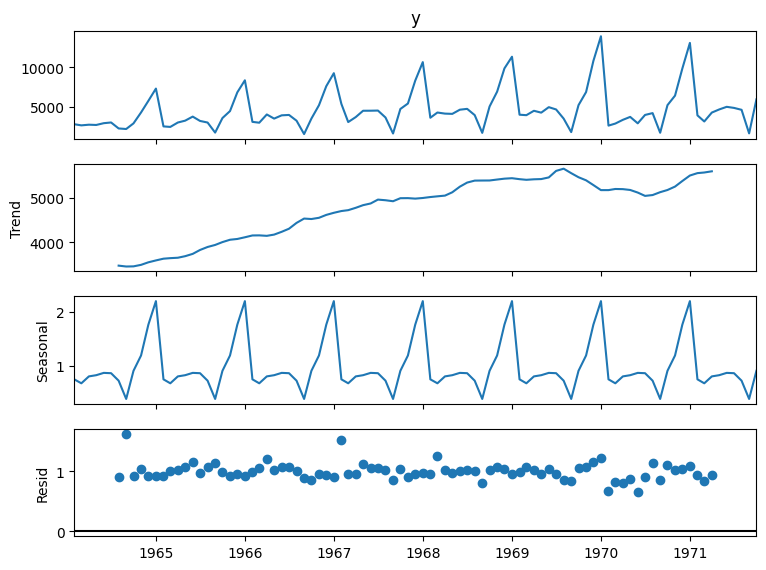

In [32]:
decomposition = seasonal_decompose(train['y'].resample('ME').mean(), model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(8,6)
plt.show()

Veamos ahora estos dos gráficos que nos hablan si tenemos algún tipo de estacionalidad (i.e., periodicidad). En particular, mensual o trimestral:

/tmp/ipython-input-573912898.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fig = month_plot(train['y'].resample('M').mean(), ylabel='Ventas')


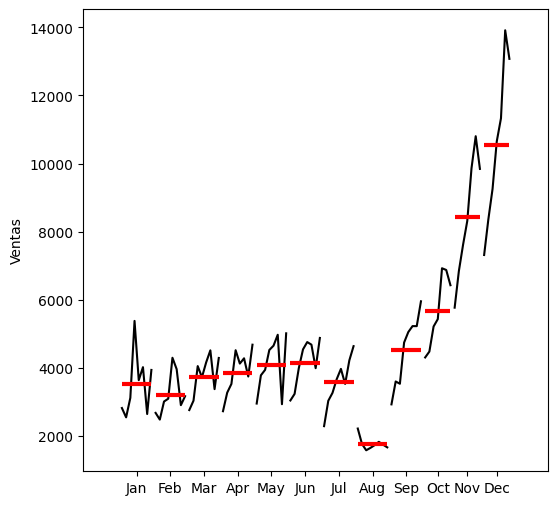

In [36]:
# Gráfica para detección de estacionalidad mensual:
fig = month_plot(train['y'].resample('M').mean(), ylabel='Ventas')
fig.set_size_inches(6,6)
plt.show()

/tmp/ipython-input-1448873505.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fig = quarter_plot(train['y'].resample('Q').mean(), ylabel='Ventas')


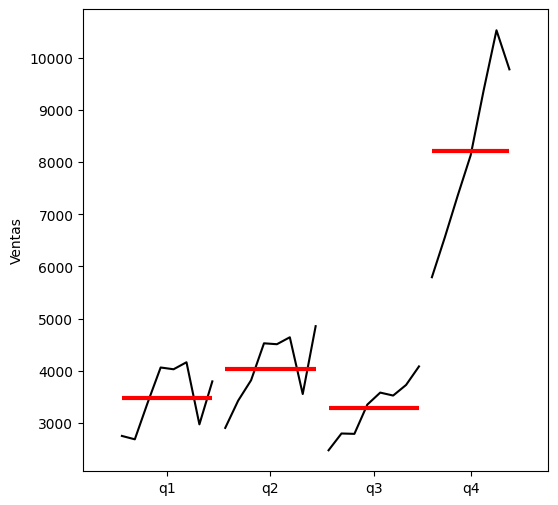

In [37]:
# graficar y detectar estacionalidad trimestral:
fig = quarter_plot(train['y'].resample('Q').mean(), ylabel='Ventas')
fig.set_size_inches(6,6)
plt.show()

Ambos gráficos indican fuertemente que los datos de ventas de champán exhiben una pronunciada estacionalidad anual, con las ventas más altas ocurriendo en el último trimestre del año, especialmente en noviembre y diciembre, y una caída significativa en las ventas a principios de año y alrededor de agosto. Esta información es crucial para modelos de pronóstico como ARIMA, ya que sugiere la necesidad de incluir componentes estacionales para capturar estos patrones recurrentes con precisión.

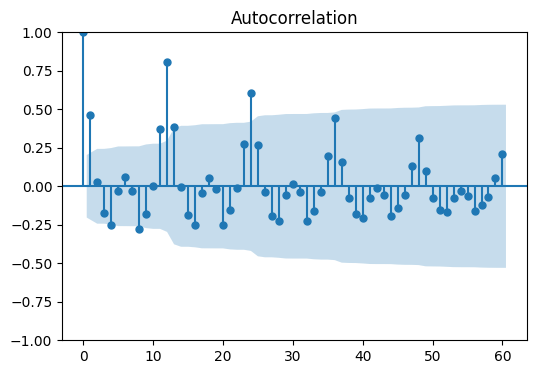

In [35]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation-Function)
fig,ax = plt.subplots(figsize = (6,4))
plot_acf(train['y'], lags=60, ax=ax)   # Eliges el número de unidades (meses) desfasadas. El número de "lags" es el número
plt.show()                          # que define la partición en el eje horizontal. El área no sombreada nos habla de
                                    # la cantidad de períodos de tiempo hacia atrás cuya información proporcionada es
                                    # significativa para la predicción futura.
                                    # También nos ayuda a detectar periodicidades

Estacionalidad Anual Pronunciada: La serie tiene un patrón que se repite cada 12 meses, lo cual es vital para cualquier modelo de pronóstico.
Presencia de Tendencia: La autocorrelación lenta indica que la serie no es estacionaria y probablemente tiene una tendencia subyacente.
Para el modelado ARIMA, esta información es fundamental. La estacionalidad tan clara sugiere que será necesario usar un modelo ARIMA estacional (SARIMA), donde se incorporan componentes estacionales (P, D, Q, S) además de los no estacionales (p, d, q). La presencia de una tendencia también implica que será necesario diferenciar la serie (aplicar d > 0 o D > 0 si la tendencia es estacional) para hacerla estacionaria antes de aplicar el modelo.

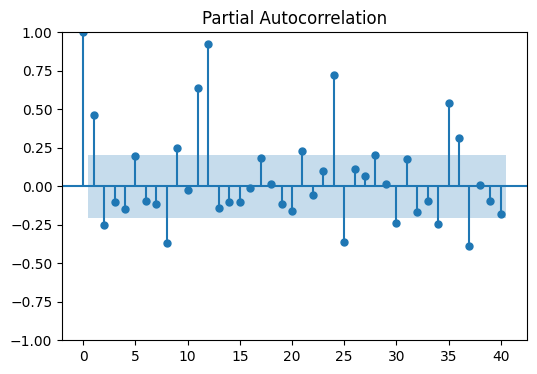

In [39]:
# Gráfico de Autocorrelación Parcial (PACF):
fig, ax = plt.subplots(figsize = (6,4))
plot_pacf(train['y'], lags = 40, ax = ax, method="ols")   # ols: regression of time series on lags of it an on constant. predetrminado method="ywm"
plt.show()

In [43]:
from statsmodels.tsa.arima.model import ARIMA

In [44]:
# Lo primero es para quitar la estacionalidad y transformar un problema
# de tipo no-estacionario (SARIMA) en uno estacionario (ARIMA):

# Diferencia de datos consecutivos en el tiempo
# y podemos ahora usar ARIMA:
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)



# Invierte las diferencias anteriores, es decir, nos regresa la estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

In [46]:
# Definamos la siguiente lista de registros de pasajeros en el tiempo:
history = [x for x in train.loc[:,'y'].values]   # train-ndarray : columna solo con los registros de pasajeros "y".
                               # history-list : lista con los datos del train.

predictions = list()   # Para incluir las predicciones que vaya generando el modelo.

for i in range(len(test['y'])):
  #
  months_in_year = 12
  diff = difference(history, months_in_year)    # diff-list: lista de los datos de diferencias para transformar SARIMA en ARIMA.

  # Generamos el modelo.
  model = ARIMA(diff, order=(3,0,13),) # Si aplicamos diff, entonces d=0 es aplicable.
  model_fit = model.fit(method_kwargs={'maxiter':300})  # Aumentar las iteraciones para evitar el WarningConvergence.

  yhat = model_fit.forecast()[0]   # prediccions (yhat) de cada registro, es un solo número flotante.
  yhat = inverse_difference(history, yhat, months_in_year)    # El "history" sigue siendo la lista de arriba.
                                                              # El nuevo "yhat" es cada un nuevo valor (float) de predicción.
  predictions.append(yhat)  # predictions-list : lista que se va incrementando al ir agregando cada predicción nueva.

  # Observaciones-reales:
  obs = test.iloc[i]['y']   #  cada dato es un flotante.
  history.append(obs)   #  history-list : se va incrementado a partir del Train con los registros-observaciones reales.

  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Error RMSE:
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-ARIMA: RMSE: %.3f' % rmse)

>Esperado-real = 6981, Predicción = 6726.531
>Esperado-real = 9851, Predicción = 9898.715
>Esperado-real = 12670, Predicción = 13641.247
>Esperado-real = 4348, Predicción = 4083.349
>Esperado-real = 3564, Predicción = 3728.547
>Esperado-real = 4577, Predicción = 4256.122
>Esperado-real = 4788, Predicción = 5060.375
>Esperado-real = 4618, Predicción = 5300.950
>Esperado-real = 5312, Predicción = 5045.039
>Esperado-real = 4298, Predicción = 4981.132
>Esperado-real = 1413, Predicción = 1692.169
>Esperado-real = 5877, Predicción = 5846.067

Error-Modelo-ARIMA: RMSE: 444.210


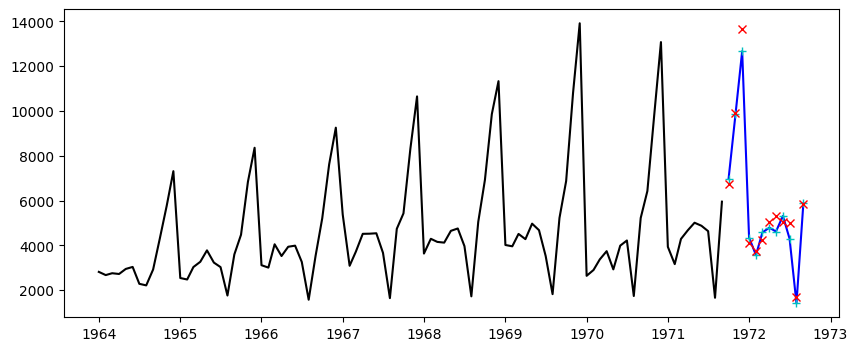

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '-b')
ax = plt.plot(test['y'], '+c')
ax = plt.plot(test.index, predictions, 'xr')

# **3 - Modelo Prophet**

In [ ]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

In [48]:
# Prophet requiere que la entrada sean dos columnas, llamadas "ds" y "y".
# Les dmos esta forma usando el DataFrame "df" inicial:

train = df.iloc[0:-12,:]
test = df.iloc[-12:,:]

In [49]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                changepoint_prior_scale=10.,   # Controla la flexibilidad de la componente Trend, mayor valor mayores fluctuaciones.
                seasonality_prior_scale=18)    # Controla la estacionalidad, mayor el valor, mayor flexibilidad en la estacionalidad.
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
# Calculamos el error RMSE:

pred_FP = model.predict(test)['yhat']
rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)


Error-Modelo-FacebookProphet: RMSE: 1322.250


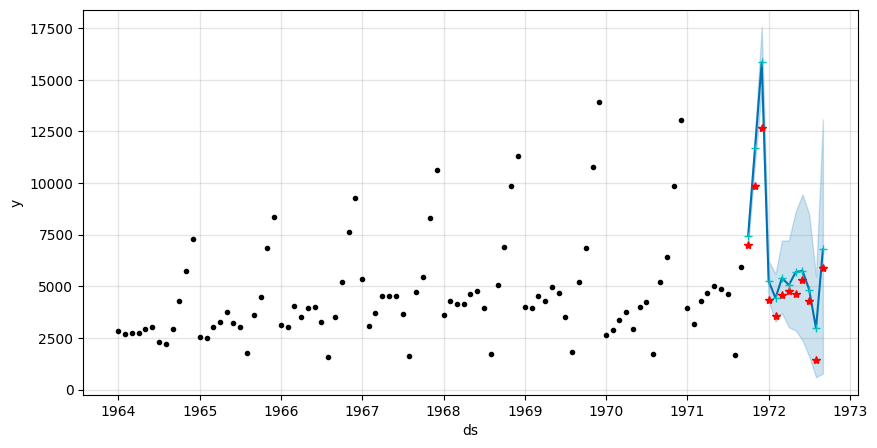

In [51]:
# La librería misma nos permite obtener las predicciones con las cotas mínima
# y máxima, además de su gráfica, como se muestra a continuación:

forecast = model.predict(test)

fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)               # Las predicciones se muestran con la línea continua, junto con su región de variabilidad de la predicción.
ax = plt.plot(test['ds'], test['y'], '*r')   # Agregamos los datos de prueba (Test) con puntos rojos, para observar la diferencia.
ax = plt.plot(test['ds'], forecast['yhat'], '+c')    # Valores reales.

# **4 - Modelo LSTM**

#### **NOTA: En general, recordemos que los modelos basados en redes neuronales son afectados de manera importante cuando la escala de los datos se va incrementando. Por ello, en este caso podría ser conveniente escalar los datos de nuestra variable temporal, por ejemplo entre 0 y 1. Tomarlo en cuenta para que al final puedes realizar las predicciones en las unidades originales.**

### **Escalado de Datos para el Modelo LSTM**

Como se menciona en la nota, los modelos de redes neuronales, como LSTM, son sensibles a la escala de los datos de entrada. Escalar los datos a un rango específico (comúnmente entre 0 y 1, o -1 y 1) puede ayudar a:

*   **Mejorar la Convergencia:** Evita que las actualizaciones de pesos en el entrenamiento sean demasiado grandes o pequeñas, lo que acelera el proceso.
*   **Estabilizar el Gradiente:** Ayuda a prevenir problemas como el gradiente que se desvanece o explota.
*   **Aumentar la Precisión:** Permite que el modelo aprenda de manera más efectiva y mejore la capacidad de generalización.

Aquí escalaremos la variable `y` (ventas) a un rango de 0 a 1 utilizando `MinMaxScaler`.

In [64]:
from sklearn.preprocessing import MinMaxScaler

# Crear una copia del DataFrame original para escalar
df_lstm = df.copy()

# Inicializar el escalador
scaler = MinMaxScaler(feature_range=(0, 1))

# Escalar la columna 'y' (ventas) y reemplazarla en df_lstm
df_lstm['y'] = scaler.fit_transform(df_lstm[['y']])

# Verificar los primeros registros del DataFrame escalado
print("First 5 scaled records:", df_lstm.head())

First 5 scaled records:           ds         y
0 1964-01-01  0.112133
1 1964-02-01  0.100696
2 1964-03-01  0.107334
3 1964-04-01  0.104615
4 1964-05-01  0.122611


In [76]:
# Continuemos con el DataFrame como en Prophet, pero ahora con los datos escalados para LSTM:

threshold_Date = '1970-10-01'   # A partir de esta fecha se empieza a generar el Test.


# Usamos df_lstm (con 'y' escalada) para preparar los datos de entrenamiento y prueba del LSTM
Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df_lstm, threshold_Date)

# Ahora que los datos escalados están preparados, re-compilamos y re-entrenamos el modelo LSTM
my_LSTM_model2 = myModel()
my_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='mse',    # función de costo "mse"
                      metrics=[tf.keras.metrics.RootMeanSquaredError()]
                      )

H = my_LSTM_model2.fit(Train_X,
                       Train_Y,
                       epochs=200,
                       validation_data=(Test_X, Test_Y),
                       callbacks=[callback], # <--- Changed from [scheduler] to [callback]
                       verbose=0 # para no imprimir todo el output del entrenamiento
                       )
print("Modelo LSTM re-entrenado con datos escalados.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo LSTM re-entrenado con datos escalados.


In [77]:
# Calculamos el error RMSE:

# Las predicciones del modelo LSTM estarán en el rango escalado (0, 1)
pred_LSTM_scaled = my_LSTM_model2.predict(Test_X)

# Desescalar las predicciones a la escala original para calcular el RMSE real
pred_LSTM = scaler.inverse_transform(pred_LSTM_scaled.reshape(-1, 1)).reshape(-1)

# Calcular el RMSE con los valores reales del test y las predicciones desescaladas
rmse = np.sqrt(mean_squared_error(test['y'].values, pred_LSTM))

print('\nError-Modelo-LSTM: RMSE: %.3f' % rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step

Error-Modelo-LSTM: RMSE: 2752.611


In [78]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

In [79]:
import tensorflow as tf

In [80]:
def preparando_datos(myData, myDate):

  # ++++++++ TRAIN +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de entrenamiento son previos a la fecha "Date" que indiques y
  # tomarán hisotriales en este caso de 12 períodos previos.
  Train_Data = myData['y'][myData['ds'] < myDate].to_numpy()

  periodo = 12   # 12 meses al año

  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []

  for i in range(0, len(Train_Data), periodo):    # observa que va formando el Train set con historiales de 12 períodos consecutivos.
    try:
      Data_Train.append(Train_Data[i : i + periodo])
    except:
      pass


  # En ocasiones hay datos perdidos, en cuyo caso la última serie
  # de datos la eliminamos:
  if len(Data_Train[-1]) < periodo:
    Data_Train.pop(-1)


  # Hay que darle la forma (dimensionalidad) que requieren los modelos
  # de aprendizaje profundo, en particular la librería de TensorFlow:
  #     (batch_size, sequence_length, input_dimension).

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, periodo, 1))

  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, periodo, 1))


  # +++++++++++ TEST +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de prueba (Test) son posteriores a la fecha "Date" y que es el
  # último ciclo que deseas predecir:
  Test_Data = myData['y'][myData['ds'] >= myDate].to_numpy()

  # inicialización de listas:
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []

  for i in range(0, len(Test_Data), periodo):
    try:
      Data_Test.append(Test_Data[i : i + periodo])
    except:
      pass


  if len(Data_Test[-1]) < periodo:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, periodo, 1))

  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, periodo, 1))


  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y


In [81]:
# Continuemos con el DataFrame como en Prophet:

threshold_Date = '1970-10-01'   # A partir de esta fecha se empieza a generar el Test.




Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df, threshold_Date)

In [82]:
# Podemos definir la manera en que el tamaño de paso (learning-rate) varíe
# en cada época. Es usual definir también algunas funciones, exponenciales,
# por ejemplo. Por el momento definamos valores constantes por intervalos:

def scheduler(epoch):

  if epoch <= 100:
    lrate = 0.05
  elif epoch <= 180:
    lrate = 0.0005
  elif epoch <=190:
    lrate = 0.00005
  else:
    lrate = (10 ** -5)

  return lrate


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 30059564.0000 - root_mean_squared_error: 5482.6606 - val_loss: 35959780.0000 - val_root_mean_squared_error: 5996.6475 - learning_rate: 0.0500
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 30032986.0000 - root_mean_squared_error: 5480.2363 - val_loss: 36074512.0000 - val_root_mean_squared_error: 6006.2061 - learning_rate: 0.0500
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 29979980.0000 - root_mean_squared_error: 5475.3975 - val_loss: 38812092.0000 - val_root_mean_squared_error: 6229.9351 - learning_rate: 0.0500
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 29908202.0000 - root_mean_squared_error: 5468.8394 - val_loss: 37169324.0000 - val_root_mean_squared_error: 6096.6650 - learning_rate: 0.0500
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 29760512.0000 - root_mean_squared_error: 5455.3198 - val_loss: 35712036.0000 - val_root_mean_squared_error: 5975.9546 - learning_rate: 0.0500
Epoch 6/200

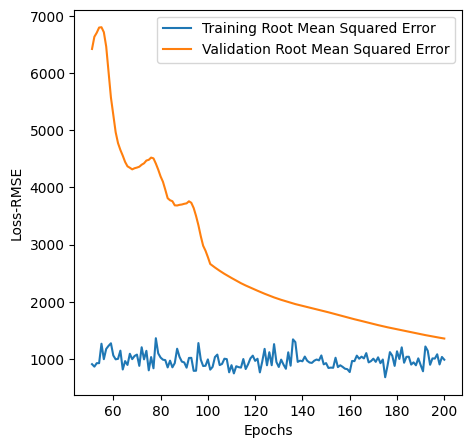

In [83]:
def myModel():

  model = tf.keras.models.Sequential([tf.keras.layers.LSTM(20, input_shape=(12, 1), activation=tf.nn.leaky_relu, return_sequences=True),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dropout(0.2),
                                      #tf.keras.layers.LSTM(20, activation=tf.nn.leaky_relu),
                                      #tf.keras.layers.BatchNormalization(),
                                      #tf.keras.layers.Dropout(0.2),

                                      tf.keras.layers.Dense(200, activation=tf.nn.leaky_relu),
                                      tf.keras.layers.Dropout(0.2),
                                      #tf.keras.layers.Dense(120, activation=tf.nn.leaky_relu),


                                      tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)
                                      ])
  return model


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


my_LSTM_model2 = myModel()

my_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='mse',    # función de costo "mse"
                      metrics=[tf.keras.metrics.RootMeanSquaredError()]   #  RMSE- despliega
                      )


H = my_LSTM_model2.fit(Train_X,
                       Train_Y,
                       epochs=200,
                       validation_data=(Test_X, Test_Y),
                       callbacks=[callback],

                       )



N = 50  # Para omitir los N primeros valores en la gráfica, que en ocasiones son
        # demasiado grandes los errores y no dejan apreciar las curvas de aprendizaje.

epochs = range(N+1, len(H.history["loss"]) + 1)

fig, ax2 = plt.subplots(figsize=(5,5))
ax2.plot(epochs, H.history["root_mean_squared_error"][N:], label = "Training Root Mean Squared Error")
ax2.plot(epochs, H.history["val_root_mean_squared_error"][N:], label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss-RMSE")
ax2.legend()

plt.show()

In [84]:
# Calculamos el error RMSE:

#pred_LSTM = H.model.predict(Test_X)
pred_LSTM = my_LSTM_model2.predict(Test_X).reshape(-1)

rmse = np.sqrt(mean_squared_error(test['y'].values, pred_LSTM))

print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step

Error-Modelo-FacebookProphet: RMSE: 1358.761


# **5 - CONCLUSIONES**

Recapitulaciones y Conclusiones Generales del Ejercicio
Este ejercicio tuvo como objetivo pronosticar las ventas mensuales de champán utilizando cuatro modelos diferentes: Ingenuo, ARIMA, Prophet y LSTM. A continuación, se presenta un resumen de los resultados y las conclusiones:

Resumen de Rendimiento (RMSE)
**1. Modelo Ingenuo: RMSE: 3135.480**

Sirve como línea base. Como se predice el valor anterior, demuestra que la serie tiene una fuerte estacionalidad y tendencia, ya que el error es muy alto cuando se desfasa un año completo.

**2. Modelo ARIMA: RMSE: 444.210**

Este modelo, al incorporar diferenciación estacional y no estacional (transformando la serie para hacerla estacionaria) y utilizando componentes AR y MA, mostró una mejora drástica en el rendimiento. Su RMSE fue el más bajo de todos, lo que indica que capturó muy bien la estacionalidad anual y la tendencia subyacente de la serie.

**3. Modelo Prophet: RMSE: 1322.250**

Prophet, diseñado específicamente para datos de series de tiempo con componentes estacionales y de tendencia, también ofreció un buen rendimiento, significativamente mejor que el modelo ingenuo. Aunque no superó a ARIMA en este caso particular, su facilidad de uso y su capacidad para modelar estacionalidades complejas (diaria, semanal, anual) lo hacen una herramienta muy práctica.

4. Modelo LSTM: RMSE: 2752.611 (después de escalar los datos)**

Este modelo, después de aplicar el escalado de datos (normalización entre 0 y 1), mostró un RMSE significativamente mejor que la ejecución inicial sin escalar. Sin embargo, en esta implementación, su rendimiento aún es inferior al de ARIMA y Prophet. Esto resalta que, si bien las redes neuronales recurrentes como las LSTM son muy potentes, a menudo requieren:
Más datos: Las LSTM suelen beneficiarse de conjuntos de datos más grandes para aprender patrones complejos.
Ajuste de hiperparámetros: Una optimización más exhaustiva de la arquitectura (número de capas, unidades, dropout, etc.) y los hiperparámetros de entrenamiento (learning_rate, tamaño de batch, etc.) es fundamental.

**Conclusiones Generales:**

La Importancia de la Estacionalidad y Tendencia: El ejercicio demostró claramente la presencia de una fuerte estacionalidad anual y una tendencia en los datos de ventas de champán. Identificar y modelar estos componentes es fundamental para obtener pronósticos precisos, como se evidenció en la gran mejora de ARIMA y Prophet sobre el modelo Ingenuo.

ARIMA para Estacionalidad Pronunciada: Para series de tiempo con estacionalidad y tendencia bien definidas y una longitud de datos moderada, los modelos SARIMA (o ARIMA estacional) pueden ser extremadamente efectivos y a menudo superar a modelos más complejos si se ajustan correctamente.

Prophet como Alternativa Robusta: Facebook Prophet es una excelente opción por su facilidad de uso y su buen rendimiento, especialmente cuando se desea capturar múltiples estacionalidades y días festivos de forma automática.

LSTM y la Preparación de Datos: El modelo LSTM mejoró drásticamente su rendimiento al escalar los datos. Esto subraya la necesidad crítica de una preprocesamiento adecuado para las redes neuronales. Aunque su RMSE aún es más alto que el de ARIMA y Prophet en este caso particular, un ajuste más profundo de sus hiperparámetros y arquitectura, junto con más datos, podría mejorar su rendimiento.

En resumen, mientras que el modelo ARIMA ofreció el mejor rendimiento en este conjunto de datos, cada modelo tiene su lugar dependiendo de las características de la serie, el volumen de datos y el esfuerzo de modelado que se esté dispuesto a invertir.

## **<<< Fin de la Actividad de la Semana - Pronósticos y Series de Tiempo >>>**